In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score, precision_score
from sklearn.model_selection import train_test_split, GroupKFold
from copy import deepcopy
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

from catboost import CatBoostRegressor, CatBoostRanker
from xgboost import XGBRegressor, XGBRanker
from sklearn.linear_model import LinearRegression
from LambdaRankNN import LambdaRankNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import json

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# TF-IDF vs BERT

1) dataframe, где 'comm' c embedding обработкой

In [ ]:
embs_comm = np.load('train_comm_embs_compress.npy')
df_embs = pd.DataFrame(embs_comm)
df = pd.concat([df, df_embs], axis=1)
del df_embs, embs_comm

X_train = df.loc[df['uid'].isin(uids_train)]
y_train = X_train['rank'].to_numpy()
uid_train = X_train['uid'].to_numpy()
X_train = X_train.drop(['rank', 'uid'], axis=1) #uid поста не берем в рассмотрение при обучении


X_test = df.loc[df['uid'].isin(uids_test)]
y_test = X_test['rank'].to_numpy()
X_test = X_test.drop(['rank', 'uid'], axis=1) #uid поста не берем в рассмотрение при обучении

print(X_train.head(), end = '\n\n\n')
print(X_test.head(), end = '\n\n\n')
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(len(df_embs))
X_train.head()
del df

2) dataframe, где 'comm' c tf-idf обработкой для слов (1,1)

In [ ]:
train_tf_idf_1_1 = np.load('1_1_train_vectors.npy')
df_train_tf_idf_1_1 = pd.DataFrame(train_tf_idf_1_1)
test_tf_idf_1_1 = np.load('1_1_test_vectors.npy')
df_test_tf_idf_1_1 = pd.DataFrame(test_tf_idf_1_1)


X_train = df.loc[df['uid'].isin(uids_train)]
y_train = X_train['rank'].to_numpy()
uid_train = X_train['uid'].to_numpy()
X_train = X_train.drop(['rank', 'uid'], axis=1) #uid поста не берем в рассмотрение при обучении
X_train = pd.concat([X_train.reset_index(drop=True), df_train_tf_idf_1_1.reset_index(drop=True)], axis=1, ignore_index = True)

X_test = df.loc[df['uid'].isin(uids_test)]
y_test = X_test['rank'].to_numpy()
X_test = X_test.drop(['rank', 'uid'], axis=1) #uid поста не берем в рассмотрение при обучении
X_test = pd.concat([X_test.reset_index(drop=True), df_test_tf_idf_1_1.reset_index(drop=True)], axis=1, ignore_index = True)

print(X_train.head(), end = '\n\n\n')
print(X_test.head(), end = '\n\n\n')
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))


#del df

3) dataframe, где 'comm' c tf-idf обработкой для словосочетаний (2,1)

In [ ]:
train_tf_idf_2_1 = np.load('2_1_train_vectors.npy')
df_train_tf_idf_2_1 = pd.DataFrame(train_tf_idf_2_1)
test_tf_idf_2_1 = np.load('2_1_test_vectors.npy')
df_test_tf_idf_2_1 = pd.DataFrame(test_tf_idf_2_1)


X_train = df.loc[df['uid'].isin(uids_train)]
y_train = X_train['rank'].to_numpy()
uid_train = X_train['uid'].to_numpy()
X_train = X_train.drop(['rank', 'uid'], axis=1) #uid поста не берем в рассмотрение при обучении
X_train =pd.concat([X_train.reset_index(drop=True), df_train_tf_idf_2_1.reset_index(drop=True)], axis=1, ignore_index = True)


X_test = df.loc[df['uid'].isin(uids_test)]
y_test = X_test['rank'].to_numpy()
X_test = X_test.drop(['rank', 'uid'], axis=1) #uid поста не берем в рассмотрение при обучении
X_test = pd.concat([X_test.reset_index(drop=True), df_test_tf_idf_2_1.reset_index(drop=True)], axis=1, ignore_index = True)

print(X_train.head(), end = '\n\n\n')
print(X_test.head(), end = '\n\n\n')
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

del df

In [ ]:
columns_to_scale = ['comm_words',
 'comm_tags',
 'comm_?!_ratio',
 'count_smiles',
 'any_upper',
 'any_digit',
 'similar_with_Jaccard',
 'post_comm',
 'post_comm2_1',
 'similar_with_Jaccard2_1',
 'comm_comm_mean',
 'comm_comm_max',
 'sent_score']

for i in columns_to_scale:
    sc = StandardScaler()
    X_train[i] = sc.fit_transform(np.expand_dims(X_train[i].to_numpy(), axis=1))
    X_test[i] = sc.transform(np.expand_dims(X_test[i].to_numpy(), axis=1))
X_train.head()

In [6]:
max_dep = [4]
iters = 2500
scores = []
scores3 = []
scorespr3 = []
best_CBRanker = None


y_test_mtr = np.zeros(shape=(y_test.shape[0], 5)) #делаем матрицу из y_test для ndcg_score
y_test_mtr[np.arange(y_test.shape[0]), y_test] = 1

for m_d in tqdm_notebook(max_dep):
    CBRanker = CatBoostRanker(iterations=iters, max_depth = m_d)
    CBRanker.fit(X_train, y_train, group_id=uid_train)
    y_pred = CBRanker.predict(X_test)


    #меняем полученные значения на позиции (0 - самое маленькое число, 4 - самое большое)
    y_pred_pos = deepcopy(y_pred)
    step = 5 #по 5 комментов на пост

    for i in range(0, len(y_pred_pos), step):
        p = y_pred_pos[i:i+step]
        y_pred_pos[i:i+step] = pd.Series(p).rank(method='first')-1

    y_pred_pos = y_pred_pos.astype(int)
    
    ndsg = ndcg_score(y_test.reshape(int(len(y_test)/5),5), y_pred.reshape(int(len(y_pred)/5),5))
    ndsg3 = ndcg_score(y_test.reshape(int(len(y_test)/5),5), y_pred.reshape(int(len(y_pred)/5),5), k=3)
    precision3 = precision_score(y_test,y_pred_pos, average ='micro')

    if len(scores)==0:
        best_CBRanker = deepcopy(CBRanker)
        scores.append(ndsg)
        scores3.append(ndsg3)
        scorespr3.append(precision3)
    else:
        if ndsg>scores[-1]:
            best_CBRanker = deepcopy(CBRanker)

        scores.append(ndsg)
        scores3.append(ndsg3)
        scorespr3.append(precision3)

ress = pd.DataFrame({'max_dep': max_dep, 'score': scores})
ress.to_excel('models/CBRanker_bert_grid_search_ress.xlsx', index=False)

Результаты

In [ ]:
# tf-idf(1,2)
print(scores)
print(scores3)
print(scorespr3)

[0.883034249624015]
[0.7723137750814244]
[0.3236099181125809]


In [ ]:
# tf-idf(1,1)
print(scores)
print(scores3)
print(scorespr3)

[0.8829475907111075]
[0.7723175282973114]
[0.32401076561873676]


In [ ]:
#embed
print(scores)
print(scores3)
print(scorespr3)

[0.8851646151399526]
[0.7765047064176831]
[0.32685105651949836]


BERT дает результаты чуть лучше (разница небольшая, т.к. основной вклад в метрику привносит comm_words)

# Data load and Train test split

In [3]:
df = pd.read_csv('cols_without_text.csv')
df.head()

,uid,rank,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit,similar_with_Jaccard,post_comm,post_comm2_1,similar_with_Jaccard2_1,comm_comm_mean,comm_comm_max,post_and_comm_sent,sent_score,comm_comm_min
0,0,0,181,0.0,0.000000,0,0,1,0.146341,0.845574,0.110414,0.018282,0.898585,0.937140,0,-0.9531,0.802385
1,0,1,76,0.0,0.000000,0,0,0,0.115385,0.878685,0.093666,0.011777,0.911822,0.940139,0,0.9081,0.836558
2,0,2,92,0.0,0.002045,0,0,0,0.030303,0.856563,0.105240,0.000890,0.914719,0.947184,0,0.7650,0.834412
3,0,3,64,0.0,0.000000,0,0,1,0.041667,0.901070,0.080324,0.001664,0.922313,0.947184,0,-0.0516,0.885877
4,0,4,14,0.0,0.000000,0,0,0,0.250000,0.918926,0.068461,0.046875,0.839808,0.885877,0,0.0000,0.802385


In [4]:
uids_train = np.load('uids_train.npy')
uids_test = np.load('uids_test.npy')

In [5]:
embs = np.load('train_comm_embs_compress.npy')
df_embs = pd.DataFrame(embs)
df = pd.concat([df, df_embs], axis=1)
del df_embs, embs

df.head()

,uid,rank,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit,similar_with_Jaccard,post_comm,...,94,95,96,97,98,99,100,101,102,103
0,0,0,181,0.0,0.000000,0,0,1,0.146341,0.845574,...,-0.196073,0.076367,0.180616,-0.358367,0.173248,0.253421,0.143938,-0.187239,-0.037344,0.089832
1,0,1,76,0.0,0.000000,0,0,0,0.115385,0.878685,...,0.029753,-0.122711,0.078702,-0.172963,-0.053846,0.079413,-0.054918,0.129317,-0.101089,-0.023801
2,0,2,92,0.0,0.002045,0,0,0,0.030303,0.856563,...,-0.031347,-0.003326,-0.002326,-0.075703,0.036030,0.007989,0.110011,-0.033566,-0.023547,0.102798
3,0,3,64,0.0,0.000000,0,0,1,0.041667,0.901070,...,0.167923,-0.123677,-0.139481,-0.220134,0.095931,-0.014950,0.011974,0.037503,-0.150952,-0.030480
4,0,4,14,0.0,0.000000,0,0,0,0.250000,0.918926,...,-0.188805,0.141527,-0.103914,-0.015326,0.032002,0.154731,0.173775,0.148716,0.225461,0.058880


In [9]:
#Делим выборку на обучающую и тестовую так, чтобы комментарии из одного поста отразились только либо в обучающей, либо в тестовой выборке

X_train = df.loc[df['uid'].isin(uids_train)]
y_train = X_train['rank'].to_numpy()
uid_train = X_train['uid'].to_numpy()
X_train = X_train.drop(['rank', 'uid'], axis=1) #uid поста не берем в рассмотрение при обучении

X_test = df.loc[df['uid'].isin(uids_test)]
y_test = X_test['rank'].to_numpy()
uid_test = X_test['uid'].to_numpy()
X_test = X_test.drop(['rank', 'uid'], axis=1) #uid поста не берем в рассмотрение при обучении

print(X_train.head(), end = '\n\n\n')
print(X_test.head(), end = '\n\n\n')
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

del df

   comm_words  comm_tags  comm_?!_ratio  count_smiles  any_upper  any_digit  \
0         181        0.0       0.000000             0          0          1   
1          76        0.0       0.000000             0          0          0   
2          92        0.0       0.002045             0          0          0   
3          64        0.0       0.000000             0          0          1   
4          14        0.0       0.000000             0          0          0   

   similar_with_Jaccard  post_comm  post_comm2_1  similar_with_Jaccard2_1  \
0              0.146341   0.845574      0.110414                 0.018282   
1              0.115385   0.878685      0.093666                 0.011777   
2              0.030303   0.856563      0.105240                 0.000890   
3              0.041667   0.901070      0.080324                 0.001664   
4              0.250000   0.918926      0.068461                 0.046875   

   ...        94        95        96        97        98      

In [10]:
columns_to_scale = ['comm_words',
 'comm_tags',
 'comm_?!_ratio',
 'count_smiles',
 'any_upper',
 'any_digit',
 'similar_with_Jaccard',
 'post_comm',
 'post_comm2_1',
 'similar_with_Jaccard2_1',
 'comm_comm_mean',
 'comm_comm_max',
 'sent_score']

for i in columns_to_scale:
    sc = StandardScaler()
    X_train[i] = sc.fit_transform(np.expand_dims(X_train[i].to_numpy(), axis=1))
    X_test[i] = sc.transform(np.expand_dims(X_test[i].to_numpy(), axis=1))
X_train.head()

,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit,similar_with_Jaccard,post_comm,post_comm2_1,similar_with_Jaccard2_1,...,94,95,96,97,98,99,100,101,102,103
0,0.927174,-0.095143,-0.349440,-0.101112,-0.179142,2.306715,1.678554,0.074375,0.087648,1.258931,...,-0.196073,0.076367,0.180616,-0.358367,0.173248,0.253421,0.143938,-0.187239,-0.037344,0.089832
1,-0.110585,-0.095143,-0.349440,-0.101112,-0.179142,-0.433517,1.179472,0.779448,-0.763071,0.675889,...,0.029753,-0.122711,0.078702,-0.172963,-0.053846,0.079413,-0.054918,0.129317,-0.101089,-0.023801
2,0.047550,-0.095143,-0.038465,-0.101112,-0.179142,-0.433517,-0.192201,0.308378,-0.175173,-0.300003,...,-0.031347,-0.003326,-0.002326,-0.075703,0.036030,0.007989,0.110011,-0.033566,-0.023547,0.102798
3,-0.229186,-0.095143,-0.349440,-0.101112,-0.179142,2.306715,-0.008998,1.256116,-1.440762,-0.230683,...,0.167923,-0.123677,-0.139481,-0.220134,0.095931,-0.014950,0.011974,0.037503,-0.150952,-0.030480
4,-0.723357,-0.095143,-0.349440,-0.101112,-0.179142,-0.433517,3.349722,1.636346,-2.043341,3.821980,...,-0.188805,0.141527,-0.103914,-0.015326,0.032002,0.154731,0.173775,0.148716,0.225461,0.058880


# CatBoostRegressor

In [11]:
#Работаем с моделью Catboostregressor

max_dep = [2, 3, 4, 5, 6, 7]
iters = 2500
scores = []
scores3 = []
scorespr3 = []
best_CBR = None

y_test_mtr = np.zeros(shape=(y_test.shape[0], 5)) #делаем матрицу из y_test для ndcg_score
y_test_mtr[np.arange(y_test.shape[0]), y_test] = 1

for m_d in tqdm_notebook(max_dep):
    CBR = CatBoostRegressor(iterations=iters, max_depth = m_d)
    CBR.fit(X_train, y_train) 

    y_pred = CBR.predict(X_test)


    #меняем полученные значения на позиции (0 - самое маленькое число, 4 - самое большое)
    y_pred_pos = deepcopy(y_pred)
    step = 5 #по 5 комментов на пост

    for i in range(0, len(y_pred_pos), step):
        p = y_pred_pos[i:i+step]
        y_pred_pos[i:i+step] = pd.Series(p).rank(method='first')-1

    y_pred_pos = y_pred_pos.astype(int)
    
    ndsg = ndcg_score(y_test.reshape(int(len(y_test)/5),5), y_pred.reshape(int(len(y_pred)/5),5))
    ndsg3 = ndcg_score(y_test.reshape(int(len(y_test)/5),5), y_pred.reshape(int(len(y_pred)/5),5), k=3)
    precision3 = precision_score(y_test,y_pred_pos, average ='micro')

    if len(scores)==0:
        best_CBR = deepcopy(CBR)
        scores.append(ndsg)
        scores3.append(ndsg3)
        scorespr3.append(precision3)
        
    else:
        if ndsg>scores[-1]:
            best_CBR = deepcopy(CBR)

        scores.append(ndsg)
        scores3.append(ndsg3)
        scorespr3.append(precision3)

best_CBR.save_model('models/best_bert_CBR.cbm')

ress = pd.DataFrame({'max_dep': max_dep, 'ndcg': scores, 'ndsg3': scores3, 'precision3': scorespr3})
ress.to_excel('models/CBR_bert_grid_search_ress.xlsx', index=False)

/tmp/ipykernel_43161/201338778.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m_d in tqdm_notebook(max_dep):


  0%|          | 0/6 [00:00<?, ?it/s]

Learning rate set to 0.049119
0:	learn: 1.4085643	total: 215ms	remaining: 8m 56s
1:	learn: 1.4034085	total: 260ms	remaining: 5m 24s
2:	learn: 1.3985838	total: 328ms	remaining: 4m 33s
3:	learn: 1.3940939	total: 364ms	remaining: 3m 47s
4:	learn: 1.3901571	total: 392ms	remaining: 3m 15s
5:	learn: 1.3864608	total: 454ms	remaining: 3m 8s
6:	learn: 1.3830557	total: 529ms	remaining: 3m 8s
7:	learn: 1.3798821	total: 580ms	remaining: 3m
8:	learn: 1.3768832	total: 664ms	remaining: 3m 3s
9:	learn: 1.3741225	total: 714ms	remaining: 2m 57s
10:	learn: 1.3713503	total: 753ms	remaining: 2m 50s
11:	learn: 1.3688728	total: 780ms	remaining: 2m 41s
12:	learn: 1.3665273	total: 810ms	remaining: 2m 34s
13:	learn: 1.3644113	total: 837ms	remaining: 2m 28s
14:	learn: 1.3625630	total: 880ms	remaining: 2m 25s
15:	learn: 1.3608054	total: 959ms	remaining: 2m 28s
16:	learn: 1.3591397	total: 1.05s	remaining: 2m 34s
17:	learn: 1.3573174	total: 1.09s	remaining: 2m 30s
18:	learn: 1.3557792	total: 1.14s	remaining: 2m 29s

In [12]:
ress

,max_dep,ndcg,ndsg3,precision3
0,2,0.881904,0.770774,0.320907
1,3,0.881070,0.769729,0.318239
2,4,0.881371,0.769977,0.319727
3,5,0.880941,0.769178,0.320460
4,6,0.880943,0.768546,0.317620
5,7,0.880162,0.766932,0.316051


# XGBRegressor

In [21]:
#Работаем с моделью XGBRegressor
from xgboost import XGBRegressor
from sklearn.metrics import ndcg_score
from copy import deepcopy
from tqdm import tqdm_notebook
from sklearn.metrics import precision_score
from collections import Counter


max_dep = [2, 3, 4, 5, 6, 7]
iters = 500
scores = []
scores3 = []
scorespr3 = []
best_XBR = None

y_test_mtr = np.zeros(shape=(y_test.shape[0], 5)) #делаем матрицу из y_test для ndcg_score
y_test_mtr[np.arange(y_test.shape[0]), y_test] = 1

for m_d in tqdm_notebook(max_dep):
    XBR = XGBRegressor(n_estimators=iters, max_depth = m_d)
    XBR.fit(X_train, y_train)

    y_pred = XBR.predict(X_test)


    #меняем полученные значения на позиции (0 - самое маленькое число, 4 - самое большое)
    y_pred_pos = deepcopy(y_pred)
    step = 5 #по 5 комментов на пост

    for i in range(0, len(y_pred_pos), step):
        p = y_pred_pos[i:i+step]

        y_pred_pos[i:i+step] = pd.Series(p).rank(method='first')-1

    y_pred_pos = y_pred_pos.astype(int)
    
    ndsg = ndcg_score(y_test.reshape(int(len(y_test)/5),5), y_pred.reshape(int(len(y_pred)/5),5))
    ndsg3 = ndcg_score(y_test.reshape(int(len(y_test)/5),5), y_pred.reshape(int(len(y_pred)/5),5), k=3)
    precision3 = precision_score(y_test,y_pred_pos, average ='micro')
    
    if len(scores)==0:
        best_XBR = deepcopy(XBR)

        scores.append(ndsg)
        scores3.append(ndsg3)
        scorespr3.append(precision3)
    else:
        if ndsg>scores[-1]:
            best_XBR = deepcopy(XBR)


        scores.append(ndsg)
        scores3.append(ndsg3)
        scorespr3.append(precision3)

best_XBR.save_model('models/best_bert_XBR.cbm')

ress = pd.DataFrame({'max_dep': max_dep, 'ndcg': ndsg, 'ndsg3': ndsg3, 'precision3': precision3})
ress.to_excel('models/XBR_bert_grid_search_ress.xlsx', index=False)

/tmp/ipykernel_42643/584520887.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m_d in tqdm_notebook(max_dep):


  0%|          | 0/6 [00:00<?, ?it/s]

In [22]:
ress

,max_dep,ndcg,ndsg3,precision3
0,2,0.866178,0.740081,0.290695
1,3,0.866178,0.740081,0.290695
2,4,0.866178,0.740081,0.290695
3,5,0.866178,0.740081,0.290695
4,6,0.866178,0.740081,0.290695
5,7,0.866178,0.740081,0.290695


# LinearRegression

In [36]:
#Работаем с моделью LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import ndcg_score
from copy import deepcopy
from tqdm import tqdm_notebook
from sklearn.metrics import precision_score
from collections import Counter

scores = []
scores3 = []
scorespr3 = []
best_CBR = None

y_test_mtr = np.zeros(shape=(y_test.shape[0], 5)) #делаем матрицу из y_test для ndcg_score
y_test_mtr[np.arange(y_test.shape[0]), y_test] = 1

LR = LinearRegression()
LR.fit(X_train, y_train)

y_pred = LR.predict(X_test)


#меняем полученные значения на позиции (0 - самое маленькое число, 4 - самое большое)
y_pred_pos = deepcopy(y_pred)
step = 5 #по 5 комментов на пост

for i in range(0, len(y_pred_pos), step):
    p = y_pred_pos[i:i+step]


    y_pred_pos[i:i+step] = pd.Series(p).rank(method='first')-1

y_pred_pos = y_pred_pos.astype(int)

ndsg = ndcg_score(y_test.reshape(int(len(y_test)/5),5), y_pred.reshape(int(len(y_pred)/5),5))
ndsg3 = ndcg_score(y_test.reshape(int(len(y_test)/5),5), y_pred.reshape(int(len(y_pred)/5),5), k=3)
precision3 = precision_score(y_test,y_pred_pos, average ='micro')

if len(scores)==0:
    best_LR = deepcopy(LR)
    scores.append(ndsg)
    scores3.append(ndsg3)
    scorespr3.append(precision3)

else:
    if ndsg>scores[-1]:
        best_LR = deepcopy(LR)

    scores.append(ndsg)
    scores3.append(ndsg3)
    scorespr3.append(precision3)

ress = pd.DataFrame({'ndcg': scores, 'ndsg3': scores3, 'precision3': scorespr3})
ress.to_excel('models/LR_bert_grid_search_ress.xlsx', index=False)

/home/ivershin/venv_venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/ivershin/venv_venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [38]:
ress

,ndcg,ndsg3,precision3
0,0.881362,0.769641,0.316761


# CatBoostRanker

In [9]:
from catboost import CatBoostRanker
from sklearn.metrics import ndcg_score
from copy import deepcopy
from tqdm import tqdm_notebook
from sklearn.metrics import precision_score
from collections import Counter

max_dep = [2, 3, 4, 5, 6, 7] #, 11, 13
iters = 1500
scores = []
scores3 = []
scorespr3 = []
best_CBRanker = None


y_test_mtr = np.zeros(shape=(y_test.shape[0], 5)) #делаем матрицу из y_test для ndcg_score
y_test_mtr[np.arange(y_test.shape[0]), y_test] = 1

for m_d in tqdm_notebook(max_dep):
    CBRanker = CatBoostRanker(iterations=iters, max_depth = m_d)
    CBRanker.fit(X_train, y_train, group_id=uid_train)
    y_pred = CBRanker.predict(X_test)


    #меняем полученные значения на позиции (0 - самое маленькое число, 4 - самое большое)
    y_pred_pos = deepcopy(y_pred)
    step = 5 #по 5 комментов на пост

    for i in range(0, len(y_pred_pos), step):
        p = y_pred_pos[i:i+step]
        y_pred_pos[i:i+step] = pd.Series(p).rank(method='first')-1

    y_pred_pos = y_pred_pos.astype(int)
    
    ndsg = ndcg_score(y_test.reshape(int(len(y_test)/5),5), y_pred.reshape(int(len(y_pred)/5),5))
    ndsg3 = ndcg_score(y_test.reshape(int(len(y_test)/5),5), y_pred.reshape(int(len(y_pred)/5),5), k=3)
    precision3 = precision_score(y_test,y_pred_pos, average ='micro')

    if len(scores)==0:
        best_CBRanker = deepcopy(CBRanker)
        scores.append(ndsg)
        scores3.append(ndsg3)
        scorespr3.append(precision3)
    else:
        if ndsg>scores[-1]:
            best_CBRanker = deepcopy(CBRanker)

        scores.append(ndsg)
        scores3.append(ndsg3)
        scorespr3.append(precision3)

best_CBRanker.save_model('models/best_bert_CBRanker.cbm')

ress = pd.DataFrame({'max_dep': max_dep, 'ndcg': scores, 'ndsg3': scores3, 'precision3': scorespr3})
ress.to_excel('models/CBRanker_bert_grid_search_ress.xlsx', index=False)

/tmp/ipykernel_43052/3003720743.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m_d in tqdm_notebook(max_dep):


  0%|          | 0/6 [00:00<?, ?it/s]

0:	total: 424ms	remaining: 10m 36s
1:	total: 849ms	remaining: 10m 35s
2:	total: 1.27s	remaining: 10m 33s
3:	total: 1.62s	remaining: 10m 7s
4:	total: 2.02s	remaining: 10m 2s
5:	total: 2.39s	remaining: 9m 56s
6:	total: 2.81s	remaining: 9m 59s
7:	total: 3.23s	remaining: 10m 2s
8:	total: 3.53s	remaining: 9m 45s
9:	total: 3.96s	remaining: 9m 50s
10:	total: 4.37s	remaining: 9m 51s
11:	total: 4.84s	remaining: 9m 59s
12:	total: 5.24s	remaining: 9m 59s
13:	total: 5.64s	remaining: 9m 58s
14:	total: 6.05s	remaining: 9m 58s
15:	total: 6.49s	remaining: 10m 2s
16:	total: 6.86s	remaining: 9m 58s
17:	total: 7.24s	remaining: 9m 56s
18:	total: 7.72s	remaining: 10m 1s
19:	total: 8.19s	remaining: 10m 5s
20:	total: 8.57s	remaining: 10m 3s
21:	total: 9.04s	remaining: 10m 7s
22:	total: 9.49s	remaining: 10m 9s
23:	total: 9.86s	remaining: 10m 6s
24:	total: 10.3s	remaining: 10m 8s
25:	total: 10.7s	remaining: 10m 7s
26:	total: 11.1s	remaining: 10m 6s
27:	total: 11.5s	remaining: 10m 2s
28:	total: 11.8s	remaining:

In [11]:
ress

,max_dep,ndcg,ndsg3,precision3
0,2,0.884238,0.775014,0.326118
1,3,0.884512,0.775719,0.326714
2,4,0.885027,0.776321,0.326920
3,5,0.885046,0.776742,0.326840
4,6,0.885054,0.776506,0.326347
5,7,0.885028,0.776785,0.325889


# XGBRanker

In [29]:
from xgboost import XGBRanker
from sklearn.metrics import ndcg_score
from copy import deepcopy
from tqdm import tqdm_notebook
from sklearn.metrics import precision_score
from collections import Counter

max_dep = [2, 3, 4, 5, 6, 7]
iters = 500
scores = []
scores3 = []
scorespr3 = []
best_XGBRanker = None


y_test_mtr = np.zeros(shape=(y_test.shape[0], 5)) #делаем матрицу из y_test для ndcg_score
y_test_mtr[np.arange(y_test.shape[0]), y_test] = 1

for m_d in tqdm_notebook(max_dep):
    XGBRank = XGBRanker(n_estimators =iters, max_depth = m_d)
    XGBRank.fit(X_train, y_train, qid =uid_train)
    y_pred = XGBRank.predict(X_test)


    #меняем полученные значения на позиции (0 - самое маленькое число, 4 - самое большое)
    y_pred_pos = deepcopy(y_pred)
    step = 5 #по 5 комментов на пост

    for i in range(0, len(y_pred_pos), step):
        p = y_pred_pos[i:i+step]
        y_pred_pos[i:i+step] = pd.Series(p).rank(method='first')-1

    y_pred_pos = y_pred_pos.astype(int)
    
    ndsg = ndcg_score(y_test.reshape(int(len(y_test)/5),5), y_pred.reshape(int(len(y_pred)/5),5))
    ndsg3 = ndcg_score(y_test.reshape(int(len(y_test)/5),5), y_pred.reshape(int(len(y_pred)/5),5), k=3)
    precision3 = precision_score(y_test,y_pred_pos, average ='micro')

    if len(scores)==0:
        best_XGBRanker = deepcopy(XGBRank)
        scores.append(ndsg)
        scores3.append(ndsg3)
        scorespr3.append(precision3)
    else:
        if ndsg>scores[-1]:
            best_XGBRanker = deepcopy(XGBRank)

        scores.append(ndsg)
        scores3.append(ndsg3)
        scorespr3.append(precision3)

best_XGBRanker.save_model('models/best_bert_XGBRanker.cbm')

ress = pd.DataFrame({'max_dep': max_dep, 'ndcg': scores, 'ndsg3': scores3, 'precision3': scorespr3})
ress.to_excel('models/XGBRanker_bert_grid_search_ress.xlsx', index=False)

/tmp/ipykernel_42975/2138796925.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m_d in tqdm_notebook(max_dep):


  0%|          | 0/6 [00:00<?, ?it/s]

In [30]:
ress

,max_dep,ndcg,ndsg3,precision3
0,2,0.884848,0.776006,0.325385
1,3,0.884277,0.774720,0.323461
2,4,0.883953,0.773536,0.323747
3,5,0.883217,0.771545,0.322384
4,6,0.881357,0.768362,0.317242
5,7,0.878696,0.762929,0.310554


# LambdaRankNN

In [ ]:
X=X_train.to_numpy()
y=y_train.copy()
qid = uid_train.copy()

In [35]:
ranker = LambdaRankNN(input_size=X.shape[1], hidden_layer_sizes=(16,8,), activation=('relu', 'relu',), solver='adam')
ranker.fit(X, y, qid, epochs=20)

Epoch 1/20
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0516
Epoch 2/20
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0509
Epoch 3/20
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0507
Epoch 4/20
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0505
Epoch 5/20
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0504
Epoch 6/20
22077/22077 [==============================] - 45s 2ms/step - loss: 0.0503
Epoch 7/20
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0502
Epoch 8/20
22077/22077 [==============================] - 43s 2ms/step - loss: 0.0502
Epoch 9/20
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0501
Epoch 10/20
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0501
Epoch 11/20
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0501
Epoch 12/20
22077/22077 [===========================

In [37]:
ranker.evaluate(X, y, qid, eval_at=3)

ndcg@3: 0.7191425522277219


In [38]:
ranker.evaluate(X, y, qid, eval_at=5)

ndcg@5: 0.8218873651546421


In [41]:
ranker = LambdaRankNN(input_size=X.shape[1], hidden_layer_sizes=(32,16,), activation=('relu', 'relu',), solver='adam')
ranker.fit(X, y, qid, epochs=10)

Epoch 1/10
22077/22077 [==============================] - 46s 2ms/step - loss: 0.0514
Epoch 2/10
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0506
Epoch 3/10
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0503
Epoch 4/10
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0500
Epoch 5/10
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0498
Epoch 6/10
22077/22077 [==============================] - 45s 2ms/step - loss: 0.0496
Epoch 7/10
22077/22077 [==============================] - 45s 2ms/step - loss: 0.0494
Epoch 8/10
22077/22077 [==============================] - 45s 2ms/step - loss: 0.0493
Epoch 9/10
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0492
Epoch 10/10
22077/22077 [==============================] - 44s 2ms/step - loss: 0.0491
ndcg: 0.8240582971608013


In [42]:
ranker.evaluate(X, y, qid, eval_at=5)

ndcg@5: 0.8240582971608013


In [43]:
ranker.evaluate(X, y, qid, eval_at=3)

ndcg@3: 0.7234163255944099


In [ ]:
X_t=X_test.to_numpy()
y_test=y_test.copy()
qid_test = uid_test.copy()

In [45]:
ranker.evaluate(X_t, y_test, qid_test, eval_at=3)

ndcg@3: 0.7036964517819693


In [46]:
ranker.evaluate(X_t, y_test, qid_test, eval_at=5)

ndcg@5: 0.8128521583684906


# LSTM

In [ ]:
def metrics(y, y_pred):

    """
    Функция для получения метрик
    """
    y_pred_pos = deepcopy(y_pred)
    len(y_pred)
    step = 5 #по 5 комментов на пост

    for i in range(0, len(y_pred_pos), step):
        p = y_pred_pos[i:i+step]
        y_pred_pos[i:i+step] = pd.Series(p).rank(method='first')-1

    y_pred_pos = y_pred_pos.astype(int)

    ndsg = ndcg_score(y.reshape(int(len(y)/5),5), y_pred.reshape(int(len(y_pred)/5),5))
    ndsg3 = ndcg_score(y.reshape(int(len(y)/5),5), y_pred.reshape(int(len(y_pred)/5),5), k=3)
    precision3 = precision_score(y,y_pred_pos, average ='micro')

    return ndsg, ndsg3, precision3

In [9]:
model = Sequential([layers.Input((119,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='tanh'),
                    layers.Dense(32, activation='tanh'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
11039/11039 [==============================] - 527s 48ms/step - loss: 1.9949 - accuracy: 0.2000
Epoch 2/5
11039/11039 [==============================] - 552s 50ms/step - loss: 1.8437 - accuracy: 0.2000
Epoch 3/5
11039/11039 [==============================] - 565s 51ms/step - loss: 1.8297 - accuracy: 0.2000
Epoch 4/5
11039/11039 [==============================] - 570s 52ms/step - loss: 1.7877 - accuracy: 0.2002
Epoch 5/5
11039/11039 [==============================] - 561s 51ms/step - loss: 1.7662 - accuracy: 0.2000


In [10]:
y_pred = model.predict(X_train)

11039/11039 [==============================] - 177s 16ms/step


In [39]:
ndsg_train, ndsg3_train, precision_3_train

(0.8800632405349326, 0.7676294595685503, 0.31709699337523356)

In [40]:
y_pred = model.predict(X_test)

2729/2729 [==============================] - 43s 16ms/step


In [42]:
ndsg_test, ndsg3_test, precision_3_test = metrics(y_test,y_pred.reshape(1,-1)[0])

In [43]:
ndsg_test, ndsg3_test, precision_3_test

(0.8783958573232319, 0.7638250838669195, 0.31662371871957856)

# Cross-Validation 

CatBoostRanker и XGBRanker имеют близкие метрики, проведем кросс-валидацию

In [8]:
def metrics(y, y_pred):

    """
    Функция для получения метрик
    """
    y_pred_pos = deepcopy(y_pred)
    len(y_pred)
    step = 5 #по 5 комментов на пост

    for i in range(0, len(y_pred_pos), step):
        p = y_pred_pos[i:i+step]
        y_pred_pos[i:i+step] = pd.Series(p).rank(method='first')-1

    y_pred_pos = y_pred_pos.astype(int)

    ndsg = ndcg_score(y.reshape(int(len(y)/5),5), y_pred.reshape(int(len(y_pred)/5),5))
    ndsg3 = ndcg_score(y.reshape(int(len(y)/5),5), y_pred.reshape(int(len(y_pred)/5),5), k=3)
    precision3 = precision_score(y,y_pred_pos, average ='micro')

    return ndsg, ndsg3, precision3

## CatBoostRanker

In [9]:
df = pd.read_csv('cols_without_text.csv')

embs_comm = np.load('train_comm_embs_compress.npy')
df_embs = pd.DataFrame(embs_comm)
df = pd.concat([df, df_embs], axis=1)
del df_embs, embs_comm
df

,uid,rank,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit,similar_with_Jaccard,post_comm,...,94,95,96,97,98,99,100,101,102,103
0,0,0,181,0.000000,0.000000,0,0,1,0.146341,0.845574,...,-0.196073,0.076367,0.180616,-0.358367,0.173248,0.253421,0.143938,-0.187239,-0.037344,0.089832
1,0,1,76,0.000000,0.000000,0,0,0,0.115385,0.878685,...,0.029753,-0.122711,0.078702,-0.172963,-0.053846,0.079413,-0.054918,0.129317,-0.101089,-0.023801
2,0,2,92,0.000000,0.002045,0,0,0,0.030303,0.856563,...,-0.031347,-0.003326,-0.002326,-0.075703,0.036030,0.007989,0.110011,-0.033566,-0.023547,0.102798
3,0,3,64,0.000000,0.000000,0,0,1,0.041667,0.901070,...,0.167923,-0.123677,-0.139481,-0.220134,0.095931,-0.014950,0.011974,0.037503,-0.150952,-0.030480
4,0,4,14,0.000000,0.000000,0,0,0,0.250000,0.918926,...,-0.188805,0.141527,-0.103914,-0.015326,0.032002,0.154731,0.173775,0.148716,0.225461,0.058880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440530,88106,0,73,0.219178,0.000000,0,0,0,0.037037,0.845693,...,0.091010,0.017373,-0.080696,-0.071689,0.109738,0.018702,0.061444,0.034959,0.014487,-0.001604
440531,88106,1,48,0.062500,0.000000,0,0,0,0.086957,0.899993,...,-0.061822,-0.047645,-0.071943,0.084906,0.169317,-0.100850,-0.070177,-0.103084,-0.064912,0.058884
440532,88106,2,44,0.000000,0.008230,0,0,0,0.190476,0.904629,...,0.107290,0.119803,-0.028635,-0.255415,0.078830,-0.134128,0.038755,0.201579,-0.052904,-0.021429
440533,88106,3,31,0.096774,0.000000,0,0,0,0.111111,0.885472,...,-0.150456,-0.036572,-0.011090,-0.205662,0.248913,0.072046,0.360585,0.194542,0.096008,0.006252


In [17]:
target = 'rank'
y_labels = df[target].values

iters = 1500

groups_uid_index = np.array(df['uid'].values)  # чтобы 

gkf = GroupKFold(n_splits=5)
cols = ['ndsg_train','ndsg3_train','precision_3_train','ndsg_test','ndsg3_test','precision_3_test']
result_of_metrics = pd.DataFrame(columns = cols)

for train_idx, test_idx in tqdm(gkf.split(df, y_labels, groups = groups_uid_index)):
    X_train = df.iloc[train_idx]
    uid_train = X_train['uid'].to_numpy()   # для параметра модели
    y_train = X_train['rank'].to_numpy()
    X_train = X_train.drop(['rank', 'uid'], axis=1)
    X_test = df.iloc[test_idx] 
    y_test = X_test['rank'].to_numpy()
    X_test = X_test.drop(['rank', 'uid'], axis=1)

    columns_to_scale = [ 'comm_words',
                         'comm_tags',
                         'comm_?!_ratio',
                         'count_smiles',
                         'any_upper',
                         'any_digit',
                         'similar_with_Jaccard',
                         'post_comm',
                         'post_comm2_1',
                         'similar_with_Jaccard2_1',
                         'comm_comm_mean',
                         'comm_comm_max',
                         'sent_score']   # выбираем признаки, которые нужно стандартизировать
    
    for i in columns_to_scale: 
        sc = StandardScaler()
        X_train[i] = sc.fit_transform(np.expand_dims(X_train[i].to_numpy(), axis=1))
        X_test[i] = sc.transform(np.expand_dims(X_test[i].to_numpy(), axis=1))

    CBRanker = CatBoostRanker(iterations=1500, max_depth = 4)
    CBRanker.fit(X_train, y_train, group_id=uid_train)

    y_train_pred  = CBRanker.predict(X_train)
    ndsg_train, ndsg3_train, precision_3_train = metrics(y_train,y_train_pred)
                                                         
    y_test_pred = CBRanker.predict(X_test)
    ndsg_test, ndsg3_test, precision_3_test = metrics(y_test,y_test_pred)
      
    result_of_metrics.loc[len(result_of_metrics.index)] = [ndsg_train,ndsg3_train,precision_3_train,ndsg_test,ndsg3_test,precision_3_test]

0it [00:00, ?it/s]

0:	total: 330ms	remaining: 8m 14s
1:	total: 689ms	remaining: 8m 36s
2:	total: 1.04s	remaining: 8m 39s
3:	total: 1.4s	remaining: 8m 45s
4:	total: 1.76s	remaining: 8m 45s
5:	total: 2.15s	remaining: 8m 54s
6:	total: 2.51s	remaining: 8m 55s
7:	total: 2.87s	remaining: 8m 55s
8:	total: 3.26s	remaining: 8m 59s
9:	total: 3.6s	remaining: 8m 57s
10:	total: 3.95s	remaining: 8m 54s
11:	total: 4.3s	remaining: 8m 52s
12:	total: 4.66s	remaining: 8m 53s
13:	total: 5.02s	remaining: 8m 52s
14:	total: 5.36s	remaining: 8m 50s
15:	total: 5.7s	remaining: 8m 48s
16:	total: 6.05s	remaining: 8m 47s
17:	total: 6.41s	remaining: 8m 48s
18:	total: 6.75s	remaining: 8m 46s
19:	total: 7.09s	remaining: 8m 44s
20:	total: 7.43s	remaining: 8m 43s
21:	total: 7.78s	remaining: 8m 42s
22:	total: 8.11s	remaining: 8m 40s
23:	total: 8.45s	remaining: 8m 39s
24:	total: 8.82s	remaining: 8m 40s
25:	total: 9.15s	remaining: 8m 38s
26:	total: 9.49s	remaining: 8m 37s
27:	total: 9.83s	remaining: 8m 36s
28:	total: 10.2s	remaining: 8m 35s

In [18]:
result_of_metrics

,ndsg_train,ndsg3_train,precision_3_train,ndsg_test,ndsg3_test,precision_3_test
0,0.889496,0.784381,0.335391,0.885336,0.777594,0.327591
1,0.889220,0.784508,0.334011,0.886488,0.778895,0.330973
2,0.889239,0.784079,0.334909,0.886580,0.779463,0.331309
3,0.889400,0.784489,0.335201,0.885875,0.778231,0.329425
4,0.889071,0.784067,0.334461,0.887097,0.779939,0.331877


In [19]:
mean_metrics = pd.DataFrame(result_of_metrics.mean(axis=0)).T
mean_metrics

,ndsg_train,ndsg3_train,precision_3_train,ndsg_test,ndsg3_test,precision_3_test
0,0.889285,0.784304,0.334795,0.886275,0.778824,0.330235


## XGBRanker

In [37]:
target = 'rank'
y_labels = df[target].values

iters = 500

groups_uid_index = np.array(df['uid'].values)  # чтобы 

gkf = GroupKFold(n_splits=5)
cols = ['ndsg_train','ndsg3_train','precision_3_train','ndsg_test','ndsg3_test','precision_3_test']
result_of_metrics = pd.DataFrame(columns = cols)

for train_idx, test_idx in tqdm(gkf.split(df, y_labels, groups = groups_uid_index)):
    X_train = df.iloc[train_idx]
    uid_train = X_train['uid'].to_numpy()   # для параметра модели
    y_train = X_train['rank'].to_numpy()
    X_train = X_train.drop(['rank', 'uid'], axis=1)
    X_test = df.iloc[test_idx] 
    y_test = X_test['rank'].to_numpy()
    X_test = X_test.drop(['rank', 'uid'], axis=1)

    columns_to_scale = [ 'comm_words',
                         'comm_tags',
                         'comm_?!_ratio',
                         'count_smiles',
                         'any_upper',
                         'any_digit',
                         'similar_with_Jaccard',
                         'post_comm',
                         'post_comm2_1',
                         'similar_with_Jaccard2_1',
                         'comm_comm_mean',
                         'comm_comm_max',
                         'sent_score']   # выбираем признаки, которые нужно стандартизировать
    
    for i in columns_to_scale: 
        sc = StandardScaler()
        X_train[i] = sc.fit_transform(np.expand_dims(X_train[i].to_numpy(), axis=1))
        X_test[i] = sc.transform(np.expand_dims(X_test[i].to_numpy(), axis=1))

    XGBR = XGBRanker(n_estimators=500, max_depth = 2)
    XGBR.fit(X_train, y_train, qid =uid_train)

    y_train_pred  = XGBR.predict(X_train)
    ndsg_train, ndsg3_train, precision_3_train = metrics(y_train,y_train_pred)
                                                         
    y_test_pred = XGBR.predict(X_test)
    ndsg_test, ndsg3_test, precision_3_test = metrics(y_test,y_test_pred)
      
    result_of_metrics.loc[len(result_of_metrics.index)] = [ndsg_train,ndsg3_train,precision_3_train,ndsg_test,ndsg3_test,precision_3_test]

0it [00:00, ?it/s]

In [38]:
result_of_metrics

,ndsg_train,ndsg3_train,precision_3_train,ndsg_test,ndsg3_test,precision_3_test
0,0.888978,0.783693,0.335975,0.884902,0.776720,0.325945
1,0.888501,0.783074,0.333606,0.886442,0.778079,0.330700
2,0.888586,0.782796,0.333547,0.886125,0.778854,0.332138
3,0.888694,0.783169,0.334776,0.885819,0.778214,0.327382
4,0.888371,0.782857,0.333158,0.886361,0.778616,0.330265


In [39]:
mean_metrics =pd.DataFrame(result_of_metrics.mean(axis=0)).T
mean_metrics

,ndsg_train,ndsg3_train,precision_3_train,ndsg_test,ndsg3_test,precision_3_test
0,0.888626,0.783118,0.334212,0.88593,0.778097,0.329286


Финальная модель - CatBoostRanker

# Shap for CatBoostRanker

In [20]:
import shap

In [21]:
explainer = shap.TreeExplainer(CBRanker)
shap_values = explainer.shap_values(X_train)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


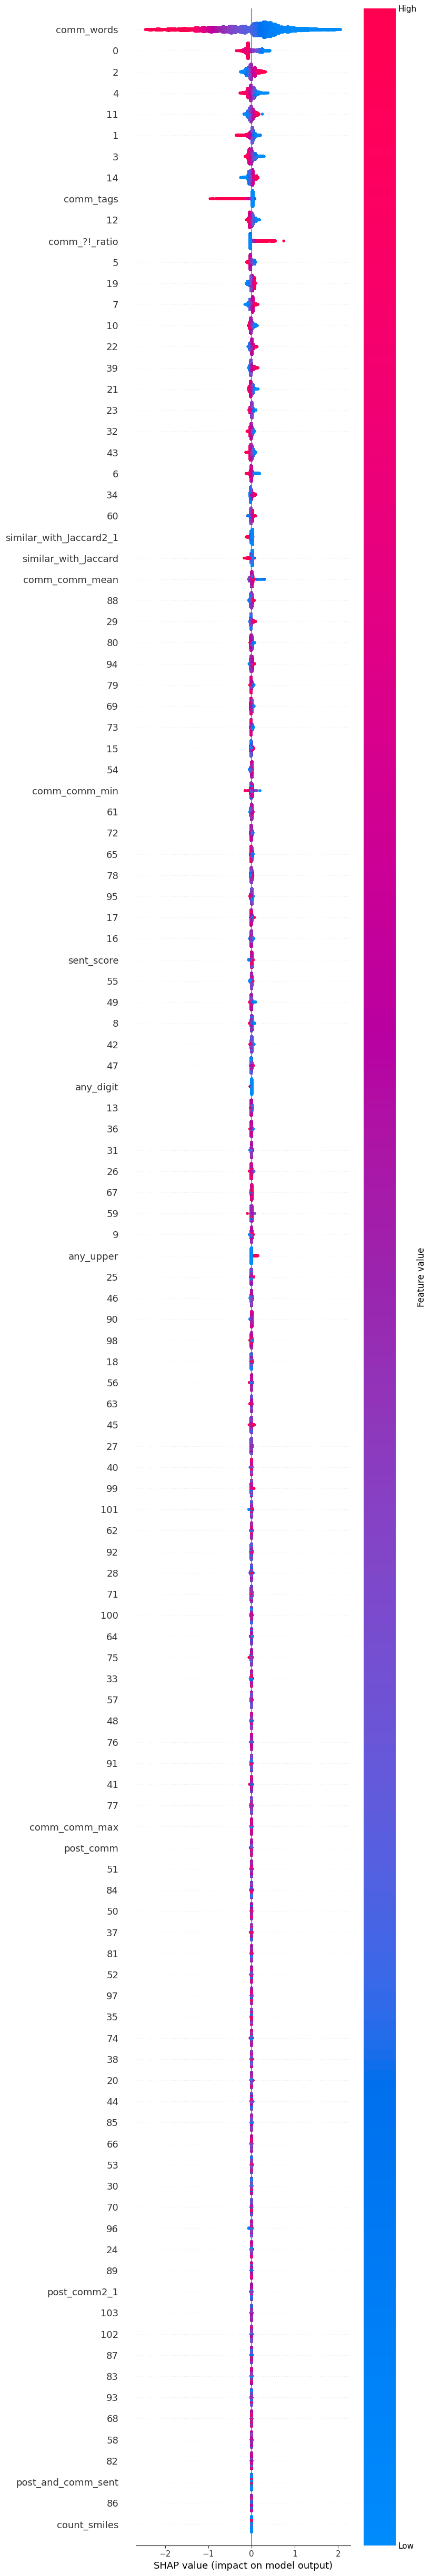

In [24]:
shap.summary_plot(shap_values, X_train, max_display=119)

In [25]:
shap.initjs()

In [26]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[5,:])

In [27]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[9,:])

In [28]:
texts = pd.read_csv('ranking_train_comments.csv')

In [29]:
texts.iloc[5,:]['comm']

"It will be curious to see where this heads in the long run.  CBS is on a tear but will it fit their image, will they try and establish control, overall agenda.  I've enjoyed last.fm for many years supporting through paypal donations each time I expire...it'll be interesting."

In [30]:
texts.iloc[9,:]['comm']

'sold out too cheaply. given their leadership position, they should have ask for at least $500m'

In [31]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [32]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[4,:])

# Test scoring

In [1]:
df = pd.read_csv('cols_without_text.csv')
df.head()

NameError: name 'pd' is not defined

In [47]:
df_test = pd.read_csv('test_after_lem.csv')
df_test=df_test.drop(['comm','post'],axis=1)
df_test.head()

,uid,rank,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit,similar_with_Jaccard,similar_with_Jaccard2_1,post_comm,post_comm2_1,comm_comm_mean,comm_comm_max,comm_comm_min,sent_score,post_and_comm_sent
0,88107,NaN,27,1,0.0,0,0,0,0.066667,0.004148,0.845085,0.110635,0.889150,0.946946,0.809826,0.0000,0
1,88107,NaN,23,4,0.0,0,0,0,0.000000,0.000000,0.864109,0.101467,0.892799,0.921799,0.870004,0.2960,0
2,88107,NaN,47,0,0.0,0,0,0,0.043478,0.001808,0.852067,0.107402,0.907617,0.946946,0.840996,-0.2500,0
3,88107,NaN,49,1,0.0,0,0,1,0.083333,0.006366,0.838686,0.113467,0.878200,0.921834,0.800234,-0.2023,0
4,88107,NaN,7,3,0.0,0,0,0,0.000000,0.000000,0.820896,0.120693,0.838114,0.901399,0.800234,0.0000,0


In [48]:
embs = np.load('train_comm_embs_compress.npy')
df_embs = pd.DataFrame(embs)
df = pd.concat([df, df_embs], axis=1)
del df_embs, embs

df.head()

,uid,rank,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit,similar_with_Jaccard,post_comm,...,94,95,96,97,98,99,100,101,102,103
0,0,0,181,0.0,0.000000,0,0,1,0.146341,0.845574,...,-0.196073,0.076367,0.180616,-0.358367,0.173248,0.253421,0.143938,-0.187239,-0.037344,0.089832
1,0,1,76,0.0,0.000000,0,0,0,0.115385,0.878685,...,0.029753,-0.122711,0.078702,-0.172963,-0.053846,0.079413,-0.054918,0.129317,-0.101089,-0.023801
2,0,2,92,0.0,0.002045,0,0,0,0.030303,0.856563,...,-0.031347,-0.003326,-0.002326,-0.075703,0.036030,0.007989,0.110011,-0.033566,-0.023547,0.102798
3,0,3,64,0.0,0.000000,0,0,1,0.041667,0.901070,...,0.167923,-0.123677,-0.139481,-0.220134,0.095931,-0.014950,0.011974,0.037503,-0.150952,-0.030480
4,0,4,14,0.0,0.000000,0,0,0,0.250000,0.918926,...,-0.188805,0.141527,-0.103914,-0.015326,0.032002,0.154731,0.173775,0.148716,0.225461,0.058880


In [49]:
embs_test = np.load('test_comm_embs_compress.npy')
df_embs_test = pd.DataFrame(embs_test)
df_test = pd.concat([df_test, df_embs_test], axis=1)
del df_embs_test, embs_test

df_test.head()

,uid,rank,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit,similar_with_Jaccard,similar_with_Jaccard2_1,...,94,95,96,97,98,99,100,101,102,103
0,88107,NaN,27,1,0.0,0,0,0,0.066667,0.004148,...,0.087203,-0.104096,-0.386221,0.141000,0.067646,-0.218894,0.045709,0.192457,0.010205,-0.069267
1,88107,NaN,23,4,0.0,0,0,0,0.000000,0.000000,...,0.180189,0.249057,-0.155671,-0.066660,-0.122382,-0.074439,-0.094186,-0.138930,0.116568,0.094695
2,88107,NaN,47,0,0.0,0,0,0,0.043478,0.001808,...,0.002956,-0.006570,-0.189496,0.288598,0.036540,-0.083761,-0.189376,0.137052,0.153537,-0.086413
3,88107,NaN,49,1,0.0,0,0,1,0.083333,0.006366,...,-0.135979,0.108967,0.084999,-0.034338,0.001532,-0.196281,-0.031366,0.046488,-0.254058,0.148836
4,88107,NaN,7,3,0.0,0,0,0,0.000000,0.000000,...,-0.386232,-0.255816,0.047582,-0.037569,-0.341694,-0.128010,0.431689,-0.158641,0.660734,0.121873


In [50]:
#Делим выборку на обучающую и тестовую так, чтобы комментарии из одного поста отразились только либо в обучающей, либо в тестовой выборке

X_train = df
y_train = X_train['rank'].to_numpy()
uid_train = X_train['uid'].to_numpy()
X_train = X_train.drop(['rank', 'uid'], axis=1) #uid поста не берем в рассмотрение при обучении

X_test = df_test
y_test = X_test['rank'].to_numpy()
uid_test = X_test['uid'].to_numpy()
X_test = X_test.drop(['rank', 'uid'], axis=1) #uid поста не берем в рассмотрение при обучении

print(X_train.head(), end = '\n\n\n')
print(X_test.head(), end = '\n\n\n')
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

del df

   comm_words  comm_tags  comm_?!_ratio  count_smiles  any_upper  any_digit  \
0         181        0.0       0.000000             0          0          1   
1          76        0.0       0.000000             0          0          0   
2          92        0.0       0.002045             0          0          0   
3          64        0.0       0.000000             0          0          1   
4          14        0.0       0.000000             0          0          0   

   similar_with_Jaccard  post_comm  post_comm2_1  similar_with_Jaccard2_1  \
0              0.146341   0.845574      0.110414                 0.018282   
1              0.115385   0.878685      0.093666                 0.011777   
2              0.030303   0.856563      0.105240                 0.000890   
3              0.041667   0.901070      0.080324                 0.001664   
4              0.250000   0.918926      0.068461                 0.046875   

   ...        94        95        96        97        98      

In [51]:
columns_to_scale = ['comm_words',
 'comm_tags',
 'comm_?!_ratio',
 'count_smiles',
 'any_upper',
 'any_digit',
 'similar_with_Jaccard',
 'post_comm',
 'post_comm2_1',
 'similar_with_Jaccard2_1',
 'comm_comm_mean',
 'comm_comm_max',
 'sent_score']

for i in columns_to_scale:
    sc = StandardScaler()
    X_train[i] = sc.fit_transform(np.expand_dims(X_train[i].to_numpy(), axis=1))
    X_test[i] = sc.transform(np.expand_dims(X_test[i].to_numpy(), axis=1))
X_train.head()

,comm_words,comm_tags,comm_?!_ratio,count_smiles,any_upper,any_digit,similar_with_Jaccard,post_comm,post_comm2_1,similar_with_Jaccard2_1,...,94,95,96,97,98,99,100,101,102,103
0,0.930216,-0.094584,-0.352018,-0.108633,-0.179223,2.309483,1.681732,0.073028,0.088888,1.262652,...,-0.196073,0.076367,0.180616,-0.358367,0.173248,0.253421,0.143938,-0.187239,-0.037344,0.089832
1,-0.109795,-0.094584,-0.352018,-0.108633,-0.179223,-0.432997,1.181589,0.778812,-0.761338,0.677906,...,0.029753,-0.122711,0.078702,-0.172963,-0.053846,0.079413,-0.054918,0.129317,-0.101089,-0.023801
2,0.048683,-0.094584,-0.040167,-0.108633,-0.179223,-0.432997,-0.193000,0.307267,-0.173780,-0.300837,...,-0.031347,-0.003326,-0.002326,-0.075703,0.036030,0.007989,0.110011,-0.033566,-0.023547,0.102798
3,-0.228653,-0.094584,-0.352018,-0.108633,-0.179223,2.309483,-0.009407,1.255962,-1.438637,-0.231314,...,0.167923,-0.123677,-0.139481,-0.220134,0.095931,-0.014950,0.011974,0.037503,-0.150952,-0.030480
4,-0.723897,-0.094584,-0.352018,-0.108633,-0.179223,-0.432997,3.356452,1.636575,-2.040867,3.833190,...,-0.188805,0.141527,-0.103914,-0.015326,0.032002,0.154731,0.173775,0.148716,0.225461,0.058880


In [52]:
CBRanker = CatBoostRanker(iterations=1500, max_depth = 4)
CBRanker.fit(X_train, y_train, group_id=uid_train)

y_train_pred  = CBRanker.predict(X_train)
ndsg_train, ndsg3_train, precision_3_train = metrics(y_train,y_train_pred)

y_test_pred = CBRanker.predict(X_test)


0:	total: 440ms	remaining: 11m
1:	total: 885ms	remaining: 11m 2s
2:	total: 1.3s	remaining: 10m 49s
3:	total: 1.73s	remaining: 10m 45s
4:	total: 2.17s	remaining: 10m 47s
5:	total: 2.58s	remaining: 10m 41s
6:	total: 3.08s	remaining: 10m 56s
7:	total: 3.5s	remaining: 10m 53s
8:	total: 3.94s	remaining: 10m 53s
9:	total: 4.39s	remaining: 10m 54s
10:	total: 4.85s	remaining: 10m 56s
11:	total: 5.29s	remaining: 10m 55s
12:	total: 5.76s	remaining: 10m 58s
13:	total: 6.2s	remaining: 10m 57s
14:	total: 6.64s	remaining: 10m 57s
15:	total: 7.1s	remaining: 10m 58s
16:	total: 7.54s	remaining: 10m 57s
17:	total: 7.99s	remaining: 10m 57s
18:	total: 8.43s	remaining: 10m 56s
19:	total: 8.88s	remaining: 10m 56s
20:	total: 9.35s	remaining: 10m 58s
21:	total: 9.77s	remaining: 10m 56s
22:	total: 10.2s	remaining: 10m 56s
23:	total: 10.7s	remaining: 10m 57s
24:	total: 11.2s	remaining: 10m 58s
25:	total: 11.6s	remaining: 10m 57s
26:	total: 12.1s	remaining: 10m 58s
27:	total: 12.5s	remaining: 10m 58s
28:	total: 

In [53]:
print(ndsg_train, ndsg3_train, precision_3_train)

0.8887829502084686 0.7833672331191902 0.33413236178737216


In [54]:
y_test_pred

array([ 0.3588012 , -0.33484634,  0.27644228, ..., -0.95074562,
       -0.90228479, -0.45780822])

In [55]:
y_pred_pos = deepcopy(y_test_pred)
step = 5 #по 5 комментов на пост

for i in range(0, len(y_pred_pos), step):
    p = y_pred_pos[i:i+step]
    y_pred_pos[i:i+step] = pd.Series(p).rank(method='first')-1

y_pred_pos = y_pred_pos.astype(int)

In [57]:
y_pred_pos[:50]

array([3, 1, 2, 0, 4, 4, 0, 2, 1, 3, 4, 1, 3, 2, 0, 1, 0, 3, 2, 4, 3, 2,
       0, 4, 1, 0, 4, 3, 2, 1, 1, 4, 0, 3, 2, 0, 4, 2, 3, 1, 2, 0, 3, 1,
       4, 2, 4, 1, 0, 3])

In [ ]:
ranking_test.jsonl

In [68]:
df_test = [json.loads(line) for line in open('ranking_test.jsonl','r')]
df_test['rank']=y_pred_pos
df_test[['uid','rank', 'comm','post']].head()

NameError: name 'json' is not defined

In [66]:
df_test[['uid','rank', 'comm','post']].to_dict()

{'uid': {0: 88107,
  1: 88107,
  2: 88107,
  3: 88107,
  4: 88107,
  5: 88108,
  6: 88108,
  7: 88108,
  8: 88108,
  9: 88108,
  10: 88109,
  11: 88109,
  12: 88109,
  13: 88109,
  14: 88109,
  15: 88110,
  16: 88110,
  17: 88110,
  18: 88110,
  19: 88110,
  20: 88111,
  21: 88111,
  22: 88111,
  23: 88111,
  24: 88111,
  25: 88112,
  26: 88112,
  27: 88112,
  28: 88112,
  29: 88112,
  30: 88113,
  31: 88113,
  32: 88113,
  33: 88113,
  34: 88113,
  35: 88114,
  36: 88114,
  37: 88114,
  38: 88114,
  39: 88114,
  40: 88115,
  41: 88115,
  42: 88115,
  43: 88115,
  44: 88115,
  45: 88116,
  46: 88116,
  47: 88116,
  48: 88116,
  49: 88116,
  50: 88117,
  51: 88117,
  52: 88117,
  53: 88117,
  54: 88117,
  55: 88118,
  56: 88118,
  57: 88118,
  58: 88118,
  59: 88118,
  60: 88119,
  61: 88119,
  62: 88119,
  63: 88119,
  64: 88119,
  65: 88120,
  66: 88120,
  67: 88120,
  68: 88120,
  69: 88120,
  70: 88121,
  71: 88121,
  72: 88121,
  73: 88121,
  74: 88121,
  75: 88122,
  76: 88122,
  

In [67]:
df_test[['uid','rank', 'comm','post']].to_dict(orient='records')

[{'uid': 88107,
  'rank': 3,
  'comm': 'wait stabilize wifi pad sith io quality start slip mac',
  'post': 'io release break phone model withdraw'},
 {'uid': 88107,
  'rank': 1,
  'comm': 'upgrade restore optionclick update downgrade back instruction url',
  'post': 'io release break phone model withdraw'},
 {'uid': 88107,
  'rank': 2,
  'comm': 'upgrade shortly release suffer consequence restore back turn note sage back order apple reregister number unable send exist contact',
  'post': 'io release break phone model withdraw'},
 {'uid': 88107,
  'rank': 0,
  'comm': 'lot pressure health kit front big flagship io feature app developer integrate ios ship showstopper bug wouldnt release apps healthkit',
  'post': 'io release break phone model withdraw'},
 {'uid': 88107,
  'rank': 4,
  'comm': 'fix update url',
  'post': 'io release break phone model withdraw'},
 {'uid': 88108,
  'rank': 4,
  'comm': 'employer good cheap market supplement make sense final coverage lot cheap start employer

In [ ]:
import jsonlines

items = [
    {'a': 1, 'b': 2},
    {'a', 123, 'b': 456},
]
with jsonlines.open('output.jsonl', 'w') as writer:
    writer.write_all(items)

In [ ]:
import json

with open('output.jsonl', 'w') as outfile:
    for entry in JSON_file:
        json.dump(entry, outfile)
        outfile.write('\n')